# 3. Analysis using Exploratory Factor Analysis Categorizations

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

import os, sys
import pandas as pd

sys.path.insert(0, 'src')
import utils
import visualizations
import analysis

In [2]:
# Exclusion parameters
min_survey_time = round(80 / 60, 4) # ~80 seconds
min_median_per_page_time = round(1 / 60, 4) # ~1 second
post_attention_check = True

'''
Commonly used Paths/Items
'''
PATH_TO_ROOT = '..'
overwrite = False
items_path = os.path.join(PATH_TO_ROOT, 'data/files/mental_capacity_items.txt')
categories_path = os.path.join(PATH_TO_ROOT, 'data/files/category_groupings.json')
save_ext = 'pdf' # File extension for saving visualizations
separate_groups = False  # If True, create separate CSV for items of different groups for analysis

'''
Save dirs
'''

# Make save directory
save_dir = os.path.join(PATH_TO_ROOT, 'analysis')
utils.ensure_dir(save_dir)
utils.informal_log("Parent save directory: {}".format(save_dir))

# Timing save dir
time_save_dir = os.path.join(save_dir, 'timings')
utils.ensure_dir(time_save_dir)
utils.informal_log("Timing save directory: {}".format(time_save_dir))

# Demographics post-exclusions
demographics_save_dir = os.path.join(save_dir, 'demographics')
utils.ensure_dir(demographics_save_dir)
utils.informal_log("Demographics save directory: {}".format(demographics_save_dir))

# Ratings CSV save dir
ratings_save_dir = os.path.join(save_dir, 'mental_capacities')
ratings_path = os.path.join(ratings_save_dir, 'ratings.csv')
utils.ensure_dir(ratings_save_dir)
utils.informal_log("Mental capacity save directory: {}".format(ratings_save_dir))

# Rating statistics save directory
rating_stats_save_dir = os.path.join(ratings_save_dir, 'statistics')
utils.ensure_dir(rating_stats_save_dir)
utils.informal_log("Mental capacity ratings statistics save directory: {}".format(rating_stats_save_dir))

# R CSV save dir for Body Heart Mind
R_input_dir = os.path.join(ratings_save_dir, 'body-heart-mind', 'R', 'input_files')
utils.ensure_dir(R_input_dir)

# R results save dir for Body Heart Mind
R_results_save_dir = os.path.join(ratings_save_dir, 'body-heart-mind', 'R', 'results')
utils.ensure_dir(R_results_save_dir)

# Save dir for factor analysis
fa_save_dir = os.path.join(ratings_save_dir, 'factor_analysis')
utils.ensure_dir(fa_save_dir)

# Save dir for k-fold factor analysis
fa_kfold_save_dir = os.path.join(fa_save_dir, 'kfold')
utils.ensure_dir(fa_kfold_save_dir)

# Save dir for factor analysis results
fa_results_save_dir = os.path.join(fa_save_dir, 'results')
utils.ensure_dir(fa_results_save_dir)

# Save dir for R analysis based on factor loading groupings
fa_R_input_dir = os.path.join(fa_results_save_dir, 'R', 'input_files')
utils.ensure_dir(fa_R_input_dir)

# Save dir for R analysis output based on factor loading groupings
fa_R_results_dir = os.path.join(fa_results_save_dir, 'R', 'results')
utils.ensure_dir(fa_R_results_dir)

# Mentioned/Unmentioned save dir
mentioned_save_dir = os.path.join(fa_save_dir, 'mentioned_analysis')
utils.ensure_dir(mentioned_save_dir)

mentioned_R_csv_save_dir = os.path.join(mentioned_save_dir, 'R', 'input_files')
utils.ensure_dir(mentioned_R_csv_save_dir)

mentioned_R_result_save_dir = os.path.join(mentioned_save_dir, 'R', 'results')
utils.ensure_dir(mentioned_R_result_save_dir)

# item-level analyses with R save dir
item_level_save_dir = os.path.join(ratings_save_dir, 'item_level')
utils.ensure_dir(item_level_save_dir)

# Attitudes save dir
attitudes_save_dir = os.path.join(save_dir, 'attitudes')
utils.ensure_dir(attitudes_save_dir)

# Attitudes R CSV save dir
addit_dv_r_csv_save_dir = os.path.join(attitudes_save_dir, 'R', 'input_files')
utils.ensure_dir(addit_dv_r_csv_save_dir)

# Attitudes R results save dir
addit_dv_r_result_save_dir = os.path.join(attitudes_save_dir, 'R', 'results')
utils.ensure_dir(addit_dv_r_result_save_dir)

# Exploratory analysis save dir
exploratory_save_dir = os.path.join(save_dir, 'exploratory')
utils.informal_log("Exploratory save directory: {}".format(exploratory_save_dir))

# Attitudes Correlations save dir
correlation_dir = os.path.join(exploratory_save_dir, 'correlations')
utils.ensure_dir(correlation_dir)

# Reliability save dir
reliability_save_dir = os.path.join(exploratory_save_dir, 'reliability')
utils.ensure_dir(reliability_save_dir)

[0625_093101] Parent save directory: ../analysis
[0625_093101] Timing save directory: ../analysis/timings
[0625_093101] Demographics save directory: ../analysis/demographics
[0625_093101] Mental capacity save directory: ../analysis/mental_capacities
[0625_093101] Mental capacity ratings statistics save directory: ../analysis/mental_capacities/statistics
[0625_093101] Exploratory save directory: ../analysis/exploratory


## Factor Analysis for bottom-up categorization
Factor analysis provides a data driven method of revealing patterns in the data that we can use to meaningfully categorize items.

In [3]:
%%R
source("src/factor_analysis.R")

# Factor Analysis
rotate <- "varimax"
fm <- "ml" # Method
scores <- "Thurstone"
sample_seed <- 123

# Process rating_df for K-fold analysis
rating_df_path <- "../analysis/mental_capacities/ratings.csv"
rating_df <- read_rating_df(rating_df_path)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages


## Perform K-Fold Cross Validation to determine number of factors by minimizing Bayesian Information Criterion (BIC)
With this method, we determined to use 3 factors

In [4]:
%%R
# K-fold
kfold_save_dir <- "../analysis/mental_capacities/factor_analysis/kfold"
k <- 5
max_n_factors <- 6

k_fold_df <- k_fold(
    rating_df = rating_df,
    k = k,
    max_n_factors = max_n_factors,
    rotate = rotate,
    fm = fm,
    scores = scores,
    seed = sample_seed,
    save_dir = kfold_save_dir,
    overwrite = FALSE
)

# Calculate average BIC for each value of K
avg_bic <- k_fold_df %>%
  group_by(n_factors) %>%
  summarise(avg_bic = mean(bic, na.rm = TRUE))
print(avg_bic)

[1] "File exists at ../analysis/mental_capacities/factor_analysis/kfold/kfold_metrics.csv and not overwriting."
# A tibble: 6 × 2
  n_factors avg_bic
      <int>   <dbl>
1         1   -968.
2         2  -2358.
3         3  -2448.
4         4  -2442.
5         5  -2414.
6         6  -2328.


### Visualize average BIC for each value of n_factors

N_factors	Mean BIC
1.0		-967.632
2.0		-2358.312
3.0		-2447.847
4.0		-2442.029
5.0		-2414.342
6.0		-2328.206
Each line represents a different fold
[0624_150132] Saved graph to ../analysis/mental_capacities/factor_analysis/kfold/bic.pdf


<Figure size 640x480 with 0 Axes>

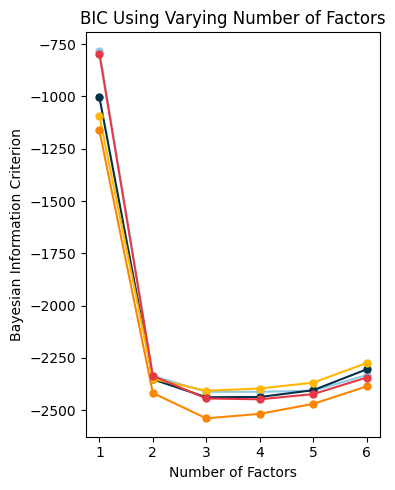

In [5]:
# Make bic_df graph in python
bic_csv_path = os.path.join(fa_kfold_save_dir, 'kfold_metrics.csv')
bic_df = utils.read_file(bic_csv_path)

bic_graph_save_path = os.path.join(fa_kfold_save_dir, 'bic.{}'.format(save_ext))

# n_folds x n_factors
xs = bic_df.pivot(index='fold', columns='n_factors', values='n_factors').to_numpy()
ys = bic_df.pivot(index='fold', columns='n_factors', values='bic').to_numpy()

bic_means = bic_df.groupby('n_factors')['bic'].mean().reset_index()
bic_means.columns = ['n_factors', 'mean_bic']
print("N_factors\tMean BIC")
for idx, row in bic_means.iterrows():
    print("{}\t\t{:.3f}".format(row['n_factors'], row['mean_bic']))
print("Each line represents a different fold")
fig, ax = visualizations.plot(
    xs=xs,
    ys=ys,
    title='BIC Using Varying Number of Factors',
    ylabel='Bayesian Information Criterion',
    xlabel='Number of Factors',
    fig_size=(4,5),
    save_path=bic_graph_save_path
)

## Run Factor Analysis on all data using n_factors = 3
Save the loadings of each item on each factor

In [6]:
%%R
n_factors <- 3
fa_save_dir <- "../analysis/mental_capacities/factor_analysis/results"

fa_results <- data_driven_fa(
    rating_df = rating_df,
    n_factors = n_factors,
    rotate = rotate,
    fm = fm,
    scores = scores,
    save_dir = fa_save_dir,
    overwrite = FALSE)

print(fa_results$metrics)
print("Rows in variance are SS loadings, Proportion Var, Cumulative Var, Proportion Explained, and Cumulative Proportion")
print("See documentation for fa in R for more details.")

Files already exist in : ../analysis/mental_capacities/factor_analysis/results 
$bic
[1] -2432.306

$mse
[1] 0.5101

$variance
        [,1]   [,2]   [,3]
[1,] 10.5599 5.8448 1.9366
[2,]  0.2640 0.1461 0.0484
[3,]  0.2640 0.4101 0.4585
[4,]  0.5757 0.3187 0.1056
[5,]  0.5757 0.8944 1.0000

$var_explained
[1] 0.4585

[1] "Rows in variance are SS loadings, Proportion Var, Cumulative Var, Proportion Explained, and Cumulative Proportion"
[1] "See documentation for fa in R for more details."


### Visualize Loadings

[0624_150856] Files exists in ../analysis/mental_capacities/factor_analysis/results
Index(['Factor1', 'Factor2', 'Factor3', 'item'], dtype='object')


/n/fs/ac-aiexhibit/portraying_llms/code/src/analysis.py:1550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loading_df['rank'] = loading_df[item_colname].map(order_mapping)


[0624_150857] Saved file to ../analysis/mental_capacities/factor_analysis/results/loadings_vertical.pdf


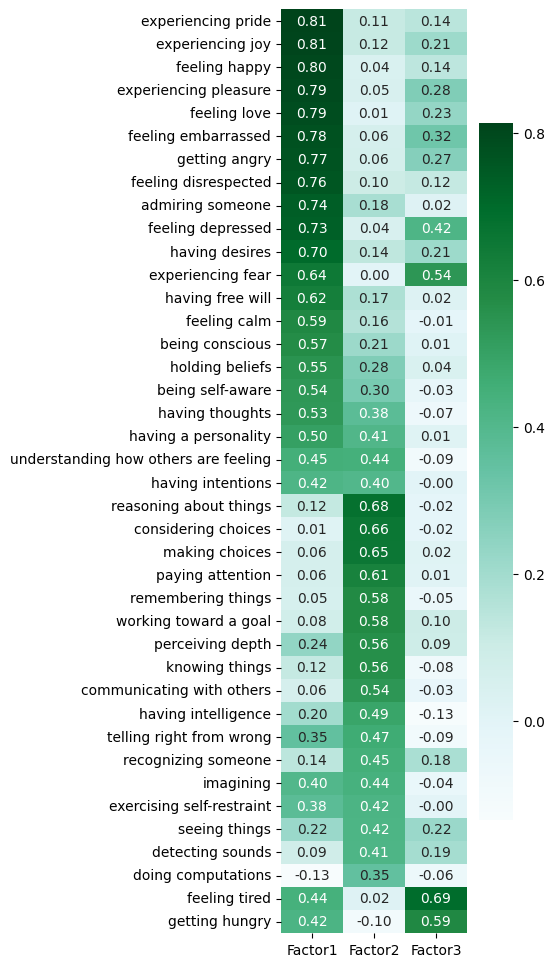

<Figure size 640x480 with 0 Axes>

In [7]:
loading_csv_path = os.path.join(fa_results_save_dir, 'loadings.csv')
loading_df = utils.read_file(loading_csv_path)

n_factors = 3

# Map names to python compatible names
items = utils.read_file(items_path)
item_mapping = dict(zip(loading_df['Unnamed: 0'], items))
loading_df['Unnamed: 0'] = loading_df['Unnamed: 0'].apply(lambda x: item_mapping[x])
column_mapper = {'Unnamed: 0': 'item'}
for i in range(n_factors):
    column_mapper['ML{}'.format(i + 1)] = 'Factor{}'.format(i + 1)

loading_df = loading_df.rename(columns=column_mapper)

# Assign categories based on maximum factor loading
loading_df_categories, _ = analysis.assign_categories(
    df=loading_df,
    item_colname='item',
    save_dir=fa_results_save_dir,
    overwrite=overwrite)

# Group items based on factor and sort in decreasing order of dominant factor
item_order = analysis.sort_by_loadings(
    loading_df=loading_df_categories,
    factors=['Factor{}'.format(i) for i in range(n_factors, 0, -1)]
)

# Visualize loadings
analysis.visualize_loadings(
    loading_df=loading_df,
    n_components=n_factors,
    orientation='vertical',
    keepcol_name='Factor',
    item_order=item_order,
    save_dir=fa_results_save_dir,
    save_ext=save_ext)

### Prepare data for running Mixed Effects Analysis with factor loading groupings

In [8]:
separate_groups = False  # If True, create separate CSV for items of different groups
fa_categories_path = os.path.join(fa_results_save_dir, 'fa_groupings.json')
rating_df = utils.read_file(ratings_path)
fa_categories = utils.read_file(fa_categories_path)

utils.informal_log("Preparing dataframes for R analysis")
analysis.prepare_R_df(
    rating_df=rating_df,
    groupings=fa_categories,
    save_dir=fa_R_input_dir,
    separate_groups=separate_groups,
    overwrite=overwrite)

utils.informal_log("\nCopying item groupings with R formatting")
items = utils.read_file(items_path)
analysis.copy_groupings(
    groupings=fa_categories,
    all_items=items,
    save_dir=fa_R_input_dir)

[0624_150919] Preparing dataframes for R analysis
File at ../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis.csv exists and not overwriting
File at ../analysis/mental_capacities/factor_analysis/results/R/input_files/paths.json exists and not overwriting
[0624_150919] 
Copying item groupings with R formatting
Saved file to ../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis_Factor1_items.txt
Saved file to ../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis_Factor2_items.txt
Saved file to ../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis_Factor3_items.txt
Saved file to ../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis_items.txt


### Run analysis based on factor loading categories
Mixed Effects Model: `rating ~ portrayal * category + (1 | pid)`

In [9]:
%%R
source("src/mixed_effect_models.R")

df_path <- "../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis.csv"
# Analysis based on factor loading groups
cat("Running analysis based on factor loading groupings...\n")
rating_analysis(
    df_path=df_path,
    save_dir="../analysis/mental_capacities/factor_analysis/results/R/results",
    save_txt=TRUE,
    n_components=3
)

Running analysis based on factor loading groupings...
[1] "File exists at ../analysis/mental_capacities/factor_analysis/results/R/results/3_components_results.txt and not overwriting."
NULL


Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'


## Effect of Unmentioned Mental Capacities

Repeat analysis with only the 35 mental capacities that were not mentioned in the LLMs-as-companions video

In [3]:
# Create file that separates items into mentioned/not mentioned (labeled mentioned/unmentioned for brevity)
def prep_mentioned_analysis(groupings_path,
                          items,
                          condition="mentioned"):
    if condition == "mentioned":
        # Items that are mentioned to in intentional video
        related_set = set([
            "communicating with others",
            "having a personality",
            "having intelligence",
            "knowing things",
            "understanding how others are feeling"])
    else:
        raise ValueError("Condition {} not yet supported".format(condition))

    if os.path.exists(groupings_path):
        groupings = utils.read_file(groupings_path)
        return groupings
    else:
        groupings = {}
    unrelated_set = set(items) - related_set


    # Make sure items are in the same order as items list
    unrelated_items = []
    for item in items:
        if item in unrelated_set:
            unrelated_items.append(item)

    related_items = []
    for item in items:
        if item in related_set:
            related_items.append(item)

    groupings[condition] = {
        'unmentioned': unrelated_items,
        'mentioned': related_items
    }

    utils.write_file(groupings, groupings_path, overwrite=overwrite)
    return groupings

mentioned_groupings_path = os.path.join(PATH_TO_ROOT, 'data/files/mentioned_groupings.json')
items = utils.read_file(items_path)
mentioned_groupings = prep_mentioned_analysis(
    groupings_path=mentioned_groupings_path,
    items=items,
    condition="mentioned"
)

# Prep data for R analysis
rating_df = utils.read_file(ratings_path)
items = utils.read_file(items_path)

utils.informal_log("Preparing DFs for mentioned vs unmentioned R analysis")
analysis.prepare_R_df(
    rating_df=rating_df,
    groupings=mentioned_groupings,
    save_dir=mentioned_R_csv_save_dir,
    separate_groups=separate_groups,
    overwrite=True
)
utils.informal_log("\nCopying item groupings with R formatting")
analysis.copy_groupings(
    groupings=mentioned_groupings,
    all_items=items,
    save_dir=mentioned_R_csv_save_dir)

[0625_093105] Preparing DFs for mentioned vs unmentioned R analysis
Saved file to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/mentioned_analysis.csv
Saved file to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/paths.json
[0625_093105] 
Copying item groupings with R formatting
Saved file to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/mentioned_analysis_unmentioned_items.txt
Saved file to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/mentioned_analysis_mentioned_items.txt
Saved file to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/mentioned_analysis_items.txt


In [ ]:
%%R
source("src/mixed_effect_models.R")

mentioned_items_analysis(
    df_path="../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/input_files/mentioned_analysis.csv",
    save_dir="../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/results",
    fa_df_path="../analysis/mental_capacities/factor_analysis/results/R/input_files/factor_analysis.csv",
    save_txt=TRUE
)

Saving results to ../analysis/mental_capacities/factor_analysis/mentioned_analysis/R/results/results.txt 


Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
refitting model(s) with ML (instead of REML)
NOTE: Results may be misleading due to involvement in interactions
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages
